# Notebook 1 : Prétraitement des Images
## Projet Le Refuge - Classification de races de chiens

Dans ce notebook, on va :
1. Télécharger le dataset Stanford Dogs
2. Sélectionner 3 races de chiens
3. Préparer les images (resize, normalisation)
4. Mettre en place la data augmentation

## 1. Import des bibliothèques

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle
import os
from os import listdir
import urllib.request
import tarfile
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from glob import glob

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## 2. Téléchargement du dataset Stanford Dogs

In [68]:
# dataset Stanford Dogs
url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
filename = "images.tar"

# Téléchargement du fichier
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)
    print("Téléchargement terminé !")
else:
    print("Le fichier est déjà téléchargé.")

#  Extraction du fichier .tar
if not os.path.exists("Images"):
    print("Extraction des images...")
    with tarfile.open(filename, 'r') as tar:
        tar.extractall()
    print("Extraction terminée ! Le dossier 'Images' est prêt.")
else:
    print("Le dossier 'Images' existe déjà.")

Le fichier est déjà téléchargé.
Le dossier 'Images' existe déjà.


## 3. Sélection de 3 races/autres puis création du DataFrame


In [ ]:
# 1. On définit le chemin
path_base = "Images"

# 2. Liste des dossiers de races sélectionnées
list_folders = ["n02099601-golden_retriever", "n02109961-Eskimo_dog", "n02085620-Chihuahua"]
list_others = ['n02088094-Afghan_hound', 'n02091467-Norwegian_elkhound', 'n02090379-redbone', 'n02085936-Maltese_dog', 'n02097047-miniature_schnauzer','n02101006-Gordon_setter','n02106550-Rottweiler']

# 3. Fonction de chargement
def data_fct_dogs(base_path, folders_list, others_list):
    data_list = []
    
    for folder in folders_list:
        full_path = os.path.join(base_path, folder)
        
        if os.path.exists(full_path):
            images = glob(os.path.join(full_path, "*.jpg"))
            print(f"Race {folder} : {len(images)} images trouvées")
            
            for img in images:
                breed_name = folder.split('-')[-1]
                data_list.append({"image_path": img, "label_name": breed_name})
        else:
            print(f"Attention : Le dossier {full_path} n'a pas été trouvé !")

    # Calcul automatique : on vise le nombre de la plus petite classe des 3 races pour équilibrer le dataset
    nb_min_classe = 150 
    # Répartir sur les 7 races "autres"
    images_par_race_autre = nb_min_classe // len(list_others)
    
    # Traitement des races "Autre"
    total_autres = 0
    for folder in others_list:
        full_path = os.path.join(base_path, folder)
        
        if os.path.exists(full_path):
            images = glob(os.path.join(full_path, "*.jpg"))
            images_selectionnees = images[:images_par_race_autre]
            total_autres += len(images_selectionnees)
            
            print(f"Autre ({folder.split('-')[-1]}) : {len(images_selectionnees)} images")
            
            for img in images_selectionnees:
                data_list.append({"image_path": img, "label_name": "Autre"})
        else:
            print(f" Dossier non trouvé : {full_path}")
    
    print(f"\nTotal classe 'Autre' : {total_autres} images")

    return pd.DataFrame(data_list)

# 3. Exécution de la fonction (avec les 2 listes en paramètres)
data_full = data_fct_dogs(path_base, list_folders, list_others)

print(f"\nTotal : {len(data_full)} images")

# 4. Vérification finale

print(f"TOTAL : {len(data_full)} images") des classes :")
print(data_full['label_name'].value_counts())

Race n02099601-golden_retriever : 150 images trouvées
Race n02109961-Eskimo_dog : 150 images trouvées
Race n02085620-Chihuahua : 152 images trouvées
Autre (Afghan_hound) : 21 images
Autre (Norwegian_elkhound) : 21 images
Autre (redbone) : 21 images
Autre (Maltese_dog) : 21 images
Autre (miniature_schnauzer) : 21 images
Autre (Gordon_setter) : 21 images
Autre (Rottweiler) : 21 images

Total classe 'Autre' : 147 images

Total : 599 images

TOTAL : 599 images

Distribution des classes :
label_name
Chihuahua           152
golden_retriever    150
Eskimo_dog          150
Autre               147
Name: count, dtype: int64


## 4. Séparation Train/Test et Encodage des labels

In [70]:
# Séparation en Train et Test (80% / 20%)
data, data_test = train_test_split(data_full, test_size=0.20, random_state=42)

# Encodage des labels
le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])
data_test["label"] = le.transform(data_test["label_name"])

print("Encodage réussi !")
print(f"Classes : {list(le.classes_)}")
print(f"\nTrain : {len(data)} images")
print(f"Test : {len(data_test)} images")
data.head()

Encodage réussi !
Classes : ['Autre', 'Chihuahua', 'Eskimo_dog', 'golden_retriever']

Train : 479 images
Test : 120 images


,image_path,label_name,label
145,Images\n02099601-golden_retriever\n02099601_87...,golden_retriever,3
9,Images\n02099601-golden_retriever\n02099601_12...,golden_retriever,3
375,Images\n02085620-Chihuahua\n02085620_3488.jpg,Chihuahua,1
522,Images\n02085936-Maltese_dog\n02085936_10307.jpg,Autre,0
188,Images\n02109961-Eskimo_dog\n02109961_17033.jpg,Eskimo_dog,2


## 5. Paramètres et Data Augmentation

Techniques de data augmentation :
- **Mirroring** : retournement horizontal (RandomFlip)
- **Rotation** : légère rotation (RandomRotation)
- **Cropping/Zoom** : zoom aléatoire (RandomZoom)

In [71]:
# Paramètres de base
IMG_SIZE = 224  # Taille standard pour la plupart des modèles CNN
BATCH_SIZE = 32

# Pipeline de Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.InputLayer(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.RandomFlip("horizontal"),   # Mirroring
    layers.RandomRotation(0.2),        # Petite rotation
    layers.RandomZoom(0.2),            # Cropping / Zoom
])

print("Data augmentation configurée !")

Data augmentation configurée !


## 6. Fonction de prétraitement des images

Cette fonction applique :
- **Resize** : redimensionnement à 224x224
- **Normalisation (Whitening)** : division par 255 pour avoir des pixels entre 0 et 1

In [72]:
def prepare_images(df, augmentation=False):
    """
    Cette fonction prépare les images pour l'entraînement.
    Si augmentation=True, elle applique les transformations aléatoires.
    """
    def load_and_preprocess(path, label):
        # 1. Lecture du fichier
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        # 2. Redimensionnement (Resize)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        # 3. Normalisation (Whitening/Rescaling)
        img = img / 255.0 
        return img, label
    
    def apply_augmentation(img, label):
        # Ajout dimension batch pour l'augmentation
        img = tf.expand_dims(img, axis=0)
        img = data_augmentation(img, training=True)
        img = tf.squeeze(img, axis=0)
        return img, label
    
    ds = tf.data.Dataset.from_tensor_slices((df['image_path'].values, df['label'].values))
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augmentation:
        ds = ds.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    
    return ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Création des datasets finaux
train_ds = prepare_images(data, augmentation=True)
test_ds = prepare_images(data_test, augmentation=False)

print("Les datasets sont prêts pour l'entraînement !")

Les datasets sont prêts pour l'entraînement !


## 7. Visualisation des images prétraitées

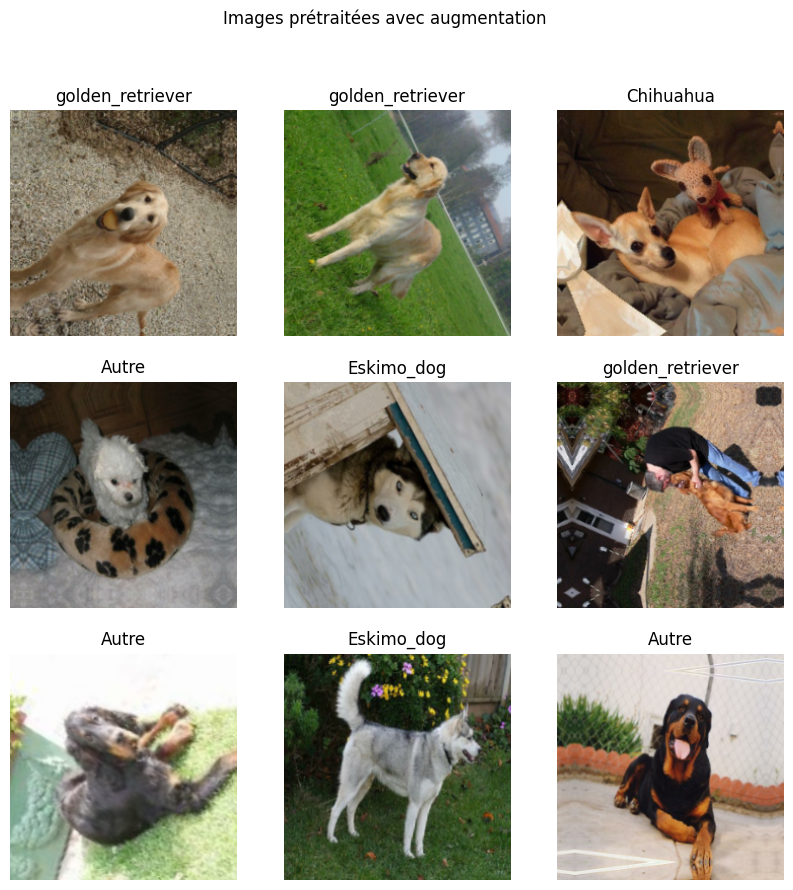

In [73]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(le.inverse_transform([labels[i].numpy()])[0])
        plt.axis("off")
plt.suptitle("Images prétraitées avec augmentation")
plt.show()

## Résumé du prétraitement

| Technique | Description |
|-----------|-------------|
| Resize | 224 x 224 pixels |
| Normalisation | Pixels entre 0 et 1 |
| RandomFlip | Miroir horizontal |
| RandomRotation | Rotation ±20% |
| RandomZoom | Zoom ±20% |


# Données sauvegardées

In [74]:
# Sauvegarder les données pour les autres notebooks
donnees_preparees = {
    'data': data,
    'data_test': data_test,
    'le': le,
    'num_classes': len(le.classes_)
}

with open('donnees_preparees.pkl', 'wb') as f:
    pickle.dump(donnees_preparees, f)

print(" Données sauvegardées pour l'entrainement des modèles")

 Données sauvegardées pour l'entrainement des modèles
